# ——  基于外卖评论的文本情感分析与LDA主题分析  ——

## 工具准备

In [192]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import style #自定义图表风格
style.use('ggplot')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
plt.rcParams['font.sans-serif'] = ['Simhei'] # 解决中文乱码问题

import re
import jieba.posseg as psg
import itertools
#conda install -c anaconda gensim
from gensim import corpora,models #主题挖掘，提取关键信息

# pip install wordcloud
from wordcloud import WordCloud,ImageColorGenerator
import collections # 词频统计库
from collections import Counter
import PIL
from PIL import Image
import seaborn as sns 

from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 

import graphviz

## 一、导入数据

In [107]:
raw_data = pd.read_csv('C:/Users/HP/Desktop/data/food_reviews.csv', encoding = 'ANSI')
raw_data.head()
raw_data.tail()

,label,review
0,pos,很快，好吃，味道足，量大
1,pos,没有送水没有送水没有送水
2,pos,非常快，态度好。
3,pos,方便，快捷，味道可口，快递给力
4,pos,菜味道很棒！送餐很及时！


,label,review
11982,neg,以前几乎天天吃，现在调料什么都不放，
11983,neg,昨天订凉皮两份，什么调料都没有放，就放了点麻油，特别难吃，丢了一份，再也不想吃了
11984,neg,"凉皮太辣,吃不下都"
11985,neg,本来迟到了还自己点！！！
11986,neg,肉夹馍不错，羊肉泡馍酱肉包很一般。凉面没想象中好吃。送餐倒是很快。


In [108]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11987 entries, 0 to 11986
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   11987 non-null  object
 1   review  11987 non-null  object
dtypes: object(2)
memory usage: 187.4+ KB


In [109]:
raw_data.columns

Index(['label', 'review'], dtype='object')

<Figure size 576x432 with 0 Axes>

<AxesSubplot:xlabel='label', ylabel='count'>

Text(0.5, 1.0, 'number of different label')

Text(0.5, 0, 'label')

Text(0, 0.5, 'count')

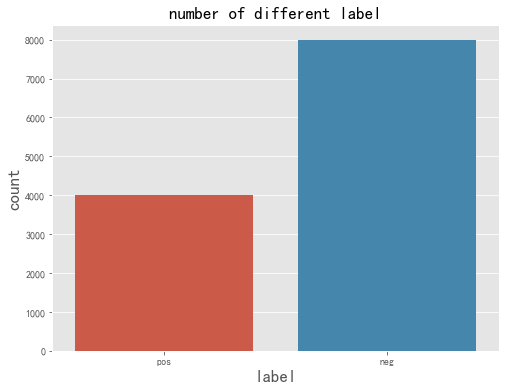

In [110]:
##绘制条形图 
plt.figure(figsize=(8,6))#设置图片大小 
sns.countplot(x='label',data = raw_data) 
plt.title('number of different label',fontsize=17)#设置标题及其字号 
plt.xlabel('label',fontsize=17)#x轴及其字号 
plt.ylabel('count',fontsize=17)#y轴及其字号

## 二、数据与处理

### （一）去重

删除系统自动为客户做出的评论。

In [111]:
reviews = raw_data.copy()
reviews = reviews[['review', 'label']]
print('去重之前：', reviews.shape[0])
reviews = reviews.drop_duplicates()
print('去重之后：',reviews.shape[0])

去重之前： 11987
去重之后： 11987


### （二）数据清洗

In [112]:
# 清洗之前
content = reviews['review']
print("清洗之前：")
for i in range(5, 9):
    print(content[i])
    print('-----------')

# 清洗之后，将数字、字母、美团、饿了么等字样都删除
info = re.compile('[0-9a-zA-Z]|美团|饿了么|')
content = content.apply(lambda x: info.sub('', x))  #替换所有匹配项
print("清洗之后：")
for i in range(5, 9):
    print(content[i])
    print('-----------')

清洗之前：
今天师傅是不是手抖了，微辣格外辣！
-----------
送餐快,态度也特别好,辛苦啦谢谢
-----------
超级快就送到了，这么冷的天气骑士们辛苦了。谢谢你们。麻辣香锅依然很好吃。
-----------
经过上次晚了2小时，这次超级快，20分钟就送到了……
-----------
清洗之后：
今天师傅是不是手抖了，微辣格外辣！
-----------
送餐快,态度也特别好,辛苦啦谢谢
-----------
超级快就送到了，这么冷的天气骑士们辛苦了。谢谢你们。麻辣香锅依然很好吃。
-----------
经过上次晚了小时，这次超级快，分钟就送到了……
-----------


### （三）分词、词性标注、去停用词、词云图展示

1、分词

目标
   
    输入：
    - review、label
    - 共有11987条评论句子
    输出：
    - 构造DF，包含： 分词、对应词性、分词所在原句子的id、分词所在原句子的content_type
    - 共有203031多行
    
    非结构化数据——>结构化数据

In [113]:
#分词
seg_content=content.apply( lambda s: [(x.word, x.flag) for x in psg.cut(s)] )  

seg_content.shape
len(seg_content)
print(seg_content[0])

(11987,)

11987

[('很快', 'd'), ('，', 'x'), ('好吃', 'v'), ('，', 'x'), ('味道', 'n'), ('足', 'a'), ('，', 'x'), ('量', 'n'), ('大', 'a')]


In [114]:
for i in range(0, 5):
    print(seg_content[i])
    print('-----------')

[('很快', 'd'), ('，', 'x'), ('好吃', 'v'), ('，', 'x'), ('味道', 'n'), ('足', 'a'), ('，', 'x'), ('量', 'n'), ('大', 'a')]
-----------
[('没有', 'v'), ('送水', 'v'), ('没有', 'v'), ('送水', 'v'), ('没有', 'v'), ('送水', 'v')]
-----------
[('非常', 'd'), ('快', 'a'), ('，', 'x'), ('态度', 'n'), ('好', 'a'), ('。', 'x')]
-----------
[('方便', 'a'), ('，', 'x'), ('快捷', 'a'), ('，', 'x'), ('味道', 'n'), ('可口', 'v'), ('，', 'x'), ('快', 'a'), ('递给', 'v'), ('力', 'n')]
-----------
[('菜', 'n'), ('味道', 'n'), ('很棒', 'a'), ('！', 'x'), ('送餐', 'v'), ('很', 'd'), ('及时', 'c'), ('！', 'x')]
-----------


In [115]:
# 统计评论词数
n_word = seg_content.apply(lambda s: len(s))

len(n_word)
n_word.head(6)

11987

0     9
1     6
2     6
3    10
4     8
5    11
Name: review, dtype: int64

In [116]:
# 得到各分词在第几条评论
n_content=[ [x+1] * y for x, y in zip(list(seg_content.index), list(n_word))] # [x+1] * y,表示复制y份，由list组成的list
index_content_long = sum(n_content, []) # 表示去掉[]，拉平,返回list
len(index_content_long)

203031

In [117]:
sum([[2,2], [3,3,3]], [])

[2, 2, 3, 3, 3]

In [118]:
# 分词及词性，去掉[]，拉平
seg_content.head()

seg_content_long = sum(seg_content, [])

seg_content_long

type(seg_content_long)
len(seg_content_long)

0    [(很快, d), (，, x), (好吃, v), (，, x), (味道, n), (足...
1    [(没有, v), (送水, v), (没有, v), (送水, v), (没有, v), ...
2    [(非常, d), (快, a), (，, x), (态度, n), (好, a), (。,...
3    [(方便, a), (，, x), (快捷, a), (，, x), (味道, n), (可...
4    [(菜, n), (味道, n), (很棒, a), (！, x), (送餐, v), (很...
Name: review, dtype: object

[('很快', 'd'),
 ('，', 'x'),
 ('好吃', 'v'),
 ('，', 'x'),
 ('味道', 'n'),
 ('足', 'a'),
 ('，', 'x'),
 ('量', 'n'),
 ('大', 'a'),
 ('没有', 'v'),
 ('送水', 'v'),
 ('没有', 'v'),
 ('送水', 'v'),
 ('没有', 'v'),
 ('送水', 'v'),
 ('非常', 'd'),
 ('快', 'a'),
 ('，', 'x'),
 ('态度', 'n'),
 ('好', 'a'),
 ('。', 'x'),
 ('方便', 'a'),
 ('，', 'x'),
 ('快捷', 'a'),
 ('，', 'x'),
 ('味道', 'n'),
 ('可口', 'v'),
 ('，', 'x'),
 ('快', 'a'),
 ('递给', 'v'),
 ('力', 'n'),
 ('菜', 'n'),
 ('味道', 'n'),
 ('很棒', 'a'),
 ('！', 'x'),
 ('送餐', 'v'),
 ('很', 'd'),
 ('及时', 'c'),
 ('！', 'x'),
 ('今天', 't'),
 ('师傅', 'nr'),
 ('是不是', 'l'),
 ('手', 'n'),
 ('抖', 'v'),
 ('了', 'ul'),
 ('，', 'x'),
 ('微辣', 'a'),
 ('格外', 'd'),
 ('辣', 'n'),
 ('！', 'x'),
 ('送餐', 'v'),
 ('快', 'a'),
 (',', 'x'),
 ('态度', 'n'),
 ('也', 'd'),
 ('特别', 'd'),
 ('好', 'a'),
 (',', 'x'),
 ('辛苦', 'a'),
 ('啦', 'y'),
 ('谢谢', 'nr'),
 ('超级', 'b'),
 ('快', 'a'),
 ('就', 'd'),
 ('送到', 'v'),
 ('了', 'ul'),
 ('，', 'x'),
 ('这么', 'r'),
 ('冷', 'a'),
 ('的', 'uj'),
 ('天气', 'n'),
 ('骑士', 'n'),
 ('们', 'k'),
 ('辛苦', 'a

list

203031

In [119]:
seg_content_long[0]

('很快', 'd')

In [120]:
# 得到加长版的分词、词性
word_long = [x[0] for x in seg_content_long]
nature_long = [x[1] for x in seg_content_long]

len(word_long)
len(nature_long)

203031

203031

In [121]:
#content_type拉长
n_content_type = [ [x]*y for x, y in zip(list(reviews['label']), list(n_word))] # [x+1]*y,表示复制y份
content_type_long = sum(n_content_type, []) #表示去掉[]，拉平

len(content_type_long)

203031

In [122]:
review_long = pd.DataFrame({'index_content': index_content_long,
                            'word':word_long,
                            'nature':nature_long,
                            'content_type':content_type_long})
review_long.shape
review_long.head()

(203031, 4)

,index_content,word,nature,content_type
0,1,很快,d,pos
1,1,，,x,pos
2,1,好吃,v,pos
3,1,，,x,pos
4,1,味道,n,pos


In [123]:
review_long.tail()

,index_content,word,nature,content_type
203026,11987,送餐,v,neg
203027,11987,倒,v,neg
203028,11987,是,v,neg
203029,11987,很快,d,neg
203030,11987,。,x,neg


2、去除标点符号和停用词

In [124]:
review_long['nature'].unique()

array(['d', 'x', 'v', 'n', 'a', 'c', 't', 'nr', 'l', 'ul', 'y', 'b', 'r',
       'uj', 'k', 'z', 'zg', 'p', 'tg', 'q', 'f', 'm', 'uz', 'u', 'nz',
       'vn', 'g', 'i', 'ns', 'ud', 'nrfg', 'ad', 'ng', 's', 'o', 'an',
       'vg', 'e', 'j', 'nrt', 'df', 'ug', 'uv', 'mq', 'yg', 'rz', 'h',
       'vd', 'nt', 'ag', 'rr', 'vq'], dtype=object)

In [125]:
# 去除标点符号
review_long_clean = review_long[review_long['nature'] != 'x'] # x表示标点符合
review_long_clean.shape

(166280, 4)

In [126]:
# 导入停用词
stop_path = open('C:/Users/HP/Desktop/data/stoplist.txt', 'r', encoding='UTF-8')
stop_words = stop_path.readlines()

len(stop_words)
stop_words[0:5]

5748

['\ufeff \n', '说\n', '人\n', '元\n', 'hellip\n']

In [127]:
# 停用词，预处理
stop_words = [word.strip('\n') for word in stop_words]
stop_words[0:5]

['\ufeff ', '说', '人', '元', 'hellip']

In [128]:
# 得到不含停用词的分词表
word_long_clean = list(set(word_long) - set(stop_words))
len(word_long_clean)

review_long_clean = review_long_clean[review_long_clean['word'].isin(word_long_clean)]
review_long_clean.shape

8992

(88128, 4)

3、在原df中，再增加一列，该分词在本条评论的位置

In [129]:
#再次统计每条评论的分词数量
n_word=review_long_clean.groupby('index_content').count()['word']
n_word

index_word=[ list(np.arange(1,x+1)) for x in list(n_word)] 
index_word_long=sum(index_word,[]) #表示去掉[]，拉平

len(index_word_long)

index_content
1         5
2         3
3         1
4         5
5         4
         ..
11983     4
11984    16
11985     3
11986     3
11987    13
Name: word, Length: 11948, dtype: int64

88128

In [130]:
review_long_clean['index_word']=index_word_long
review_long_clean.head()

,index_content,word,nature,content_type,index_word
0,1,很快,d,pos,1
2,1,好吃,v,pos,2
4,1,味道,n,pos,3
5,1,足,a,pos,4
7,1,量,n,pos,5


In [131]:
review_long_clean.to_csv('C:/Users/HP/Desktop/data//1_review_long_clean.csv')

4、提取名词

In [132]:
n_review_long_clean = review_long_clean[[ 'n' in nat for nat in review_long_clean.nature]]
n_review_long_clean.shape
n_review_long_clean.head()

(35121, 5)

,index_content,word,nature,content_type,index_word
4,1,味道,n,pos,3
7,1,量,n,pos,5
18,3,态度,n,pos,1
25,4,味道,n,pos,2
30,4,力,n,pos,5


In [133]:
n_review_long_clean.nature.value_counts()
n_review_long_clean.to_csv('C:/Users/HP/Desktop/data/1_n_review_long_clean.csv')

n       30554
nr       1692
ns        979
vn        833
nz        472
ng        419
an         80
nrt        75
nt         12
nrfg        5
Name: nature, dtype: int64

5、词云图

<Figure size 1440x720 with 0 Axes>

(-0.5, 563.5, 515.5, -0.5)

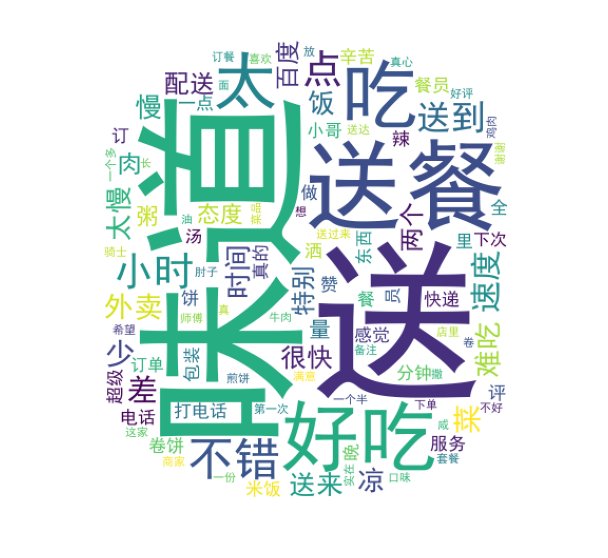

In [134]:
#分词后的词云图
font = r"C:/Windows/Fonts/simhei.TTF"
background_image=plt.imread('C:/Users/HP/Desktop/data/pic1.jpg')

wordcloud = WordCloud(font_path = font, max_words = 100, 
                      background_color = 'white', mask = background_image) #width=1600,height=1200, mode='RGBA'
wordcloud.generate_from_frequencies(Counter(review_long_clean.word.values))
wordcloud.to_file('wordcloud_after_segmentation.png')

plt.figure(figsize = (20, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

<Figure size 1440x720 with 0 Axes>

(-0.5, 563.5, 515.5, -0.5)

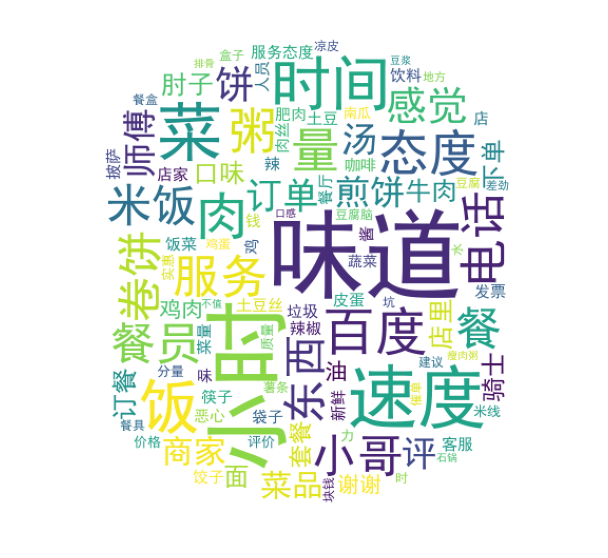

In [135]:
#分词后的词云图（名词）
wordcloud = WordCloud(font_path = font, max_words = 100, mode='RGBA' ,
                      background_color = 'white', mask = background_image) #width=1600,height=1200
wordcloud.generate_from_frequencies(Counter(n_review_long_clean.word.values))
wordcloud.to_file('wordcloud_for_noun_after_segmentation.png')

plt.figure(figsize = (20, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# 三、模型构建

## （一）情感分析

1、导入评价情感词

In [136]:
#来自知网发布的情感分析词语集
pos_comment = pd.read_csv('C:/Users/HP/Desktop/data/正面评价词语（中文）.txt', header = None, sep = '\n', encoding = 'utf-8') 
neg_comment = pd.read_csv('C:/Users/HP/Desktop/data/负面评价词语（中文）.txt', header = None, sep = '\n', encoding = 'utf-8')


pos_emotion = pd.read_csv('C:/Users/HP/Desktop/data/正面情感词语（中文）.txt', header = None, sep = '\n', encoding = 'utf-8')
neg_emotion = pd.read_csv('C:/Users/HP/Desktop/data/负面情感词语（中文）.txt', header = None, sep = '\n', encoding = 'utf-8')

In [137]:
pos_comment.shape
neg_comment.shape

pos_emotion.shape
neg_emotion.shape

(3743, 1)

(3138, 1)

(833, 1)

(1251, 1)

In [138]:
pos = pd.concat([pos_comment, pos_emotion], axis = 0)
pos.shape

neg = pd.concat([neg_comment, neg_emotion], axis = 0)
neg.shape

(4576, 1)

(4389, 1)

2、增加新词

In [139]:
# 2、增加新词
c1 = '种草'
c1 in pos.values

c2 = '好吃'
c2 in pos.values

c3 = '美味'
c3 in pos.values

d = '踩雷'
d in neg.values

False

False

False

False

In [140]:
new_pos = pd.Series(['种草','好吃','美味','很棒','快捷'])
new_neg = pd.Series(['踩雷'])
positive = pd.concat([pos,new_pos], axis = 0)
positive.shape

negative=pd.concat([neg,new_neg],axis=0)
negative.shape

(4581, 1)

(4390, 1)

In [141]:
positive.columns = ['review']
positive['weight'] = pd.Series([1]*len(positive))
positive.head()

,review,weight
0,侻,1
1,俶傥,1
2,僄,1
3,劼,1
4,嫕,1


In [142]:
negative.columns = ['review']
negative['weight'] = pd.Series([-1] * len(negative))
negative.head()

,review,weight
0,僄,-1
1,啰啰唆唆,-1
2,啰啰嗦嗦,-1
3,啰里啰唆,-1
4,啰里啰嗦,-1


In [143]:
pos_neg = pd.concat([positive, negative], axis = 0)
pos_neg.shape

(8971, 2)

3、合并到review_long_clean中

In [144]:
#表联接
data = review_long_clean.copy()
review_mltype = pd.merge(data, pos_neg, how = 'left', left_on = 'word', right_on = 'review')
review_mltype.shape

review_mltype = review_mltype.drop(['review'], axis = 1)
review_mltype = review_mltype.replace(np.nan,0)
review_mltype.head()

(88128, 7)

,index_content,word,nature,content_type,index_word,weight
0,1,很快,d,pos,1,1.0
1,1,好吃,v,pos,2,1.0
2,1,味道,n,pos,3,0.0
3,1,足,a,pos,4,0.0
4,1,量,n,pos,5,0.0


4、修正情感倾向

如有多重否定，那么奇数否定是否定，偶数否定是肯定

看该情感词前2个词，来判罚否定的语气。如果在句首，则没有否词，如果在句子的第二次词，则看前1个词，来判断否定的语气。

In [145]:
notdict = pd.read_csv('C:/Users/HP/Desktop/data/not.csv')
notdict.shape

notdict['freq'] = [1] * len(notdict)
notdict.head()

(21, 1)

,term,freq
0,不,1
1,没,1
2,无,1
3,非,1
4,莫,1


In [146]:
review_mltype['amend_weight'] = review_mltype['weight']
review_mltype['id'] = np.arange(0, review_mltype.shape[0])
review_mltype.head()

,index_content,word,nature,content_type,index_word,weight,amend_weight,id
0,1,很快,d,pos,1,1.0,1.0,0
1,1,好吃,v,pos,2,1.0,1.0,1
2,1,味道,n,pos,3,0.0,0.0,2
3,1,足,a,pos,4,0.0,0.0,3
4,1,量,n,pos,5,0.0,0.0,4


In [147]:
# 只保留有情感值的行
only_review_mltype = review_mltype[review_mltype['weight'] != 0]
only_review_mltype.index = np.arange(0, only_review_mltype.shape[0]) #索引重置
only_review_mltype.shape
only_review_mltype.head()

(5606, 8)

,index_content,word,nature,content_type,index_word,weight,amend_weight,id
0,1,很快,d,pos,1,1.0,1.0,0
1,1,好吃,v,pos,2,1.0,1.0,1
2,4,快捷,a,pos,1,1.0,1.0,9
3,5,很棒,a,pos,3,1.0,1.0,16
4,7,辛苦,a,pos,4,1.0,1.0,26


In [148]:
i=4
review_i = review_mltype[review_mltype['index_content'] == only_review_mltype['index_content'][i]]
review_i#第i个情感词的评论

,index_content,word,nature,content_type,index_word,weight,amend_weight,id
23,7,送餐,v,pos,1,0.0,0.0,23
24,7,态度,n,pos,2,0.0,0.0,24
25,7,特别,d,pos,3,0.0,0.0,25
26,7,辛苦,a,pos,4,1.0,1.0,26
27,7,谢谢,nr,pos,5,0.0,0.0,27


In [149]:
#看该情感词前2个词，来判罚否定的语气。如果在句首，则没有否词，如果在句子的第二次词，则看前1个词，来判断否定的语气。
index = only_review_mltype['id']

for i in range(0,only_review_mltype.shape[0]):
    review_i = review_mltype[review_mltype['index_content'] == only_review_mltype['index_content'][i]] #第i个情感词的评论
    review_i.index = np.arange(0, review_i.shape[0])#重置索引后，索引值等价于index_word
    word_ind = only_review_mltype['index_word'][i] #第i个情感值在该条评论的位置
    
    #第一种，在句首。则不用判断
    #第二种，在评论的第2个为位置
    if word_ind == 2:
        ne = sum( [ review_i['word'][word_ind-1] in notdict['term']  ] )
        if ne == 1:
            review_mltype['amend_weight'][index[i]] = -( review_mltype['weight'][index[i]] )
    #第三种，在评论的第2个位置以后       
    elif word_ind > 2:
        ne = sum( [ word in notdict['term'] for word in review_i['word'][[word_ind-1, word_ind-2]] ] ) # 注意用中括号[word_ind-1,word_ind-2]
        if ne == 1:
            review_mltype['amend_weight'][index[i]] = -( review_mltype['weight'][index[i]] )

In [150]:
review_mltype.shape
review_mltype[(review_mltype['weight'] - review_mltype['amend_weight']) != 0] #说明两列值一样

(88128, 8)

,index_content,word,nature,content_type,index_word,weight,amend_weight,id


5、计算每条评论情感值

In [151]:
review_mltype.head()

,index_content,word,nature,content_type,index_word,weight,amend_weight,id
0,1,很快,d,pos,1,1.0,1.0,0
1,1,好吃,v,pos,2,1.0,1.0,1
2,1,味道,n,pos,3,0.0,0.0,2
3,1,足,a,pos,4,0.0,0.0,3
4,1,量,n,pos,5,0.0,0.0,4


In [152]:
emotion_value = review_mltype.groupby('index_content', as_index = False)['amend_weight'].sum()
emotion_value.head()
emotion_value.to_csv('C:/Users/HP/Desktop/data/1_emotion_value', index = True, header = True)

,index_content,amend_weight
0,1,2.0
1,2,0.0
2,3,0.0
3,4,1.0
4,5,1.0


6、查看情感分析结果

In [153]:
#每条评论的amend_weight总和不等于零
content_emotion_value = emotion_value.copy()
content_emotion_value.shape
content_emotion_value = content_emotion_value[content_emotion_value['amend_weight']!=0]
content_emotion_value['ml_type'] = ''
content_emotion_value['ml_type'][content_emotion_value['amend_weight'] > 0] = 'pos'
content_emotion_value['ml_type'][content_emotion_value['amend_weight'] < 0] = 'neg'

content_emotion_value.shape
content_emotion_value.head()

(11948, 2)

<ipython-input-153-43c68322e543>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_emotion_value['ml_type'][content_emotion_value['amend_weight'] > 0] = 'pos'
<ipython-input-153-43c68322e543>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_emotion_value['ml_type'][content_emotion_value['amend_weight'] < 0] = 'neg'


(4297, 3)

,index_content,amend_weight,ml_type
0,1,2.0,pos
3,4,1.0,pos
4,5,1.0,pos
6,7,1.0,pos
7,8,2.0,pos


In [154]:
#每条评论的amend_weight总和等于零
#这个方法其实不好用，有一半以上的评论区分不出正、负情感。

content_emotion_value0 = emotion_value.copy()
content_emotion_value0 = content_emotion_value0[content_emotion_value0['amend_weight'] == 0]
content_emotion_value0.head()

,index_content,amend_weight
1,2,0.0
2,3,0.0
5,6,0.0
8,9,0.0
9,10,0.0


In [155]:
raw_data.review[6]
raw_data.review[7]
raw_data.review[8]

'送餐快,态度也特别好,辛苦啦谢谢'

'超级快就送到了，这么冷的天气骑士们辛苦了。谢谢你们。麻辣香锅依然很好吃。'

'经过上次晚了2小时，这次超级快，20分钟就送到了……'

In [156]:
#合并到大表中

content_emotion_value = content_emotion_value.drop(['amend_weight'], axis = 1)
review_mltype.shape
review_mltype = pd.merge(review_mltype, content_emotion_value, how = 'left', left_on = 'index_content', right_on = 'index_content')
review_mltype = review_mltype.drop(['id'], axis = 1)
review_mltype.shape
review_mltype.head()

review_mltype.to_csv('C:/Users/HP/Desktop/data/1_review_mltype', index = True, header = True)

(88128, 8)

(88128, 8)

,index_content,word,nature,content_type,index_word,weight,amend_weight,ml_type
0,1,很快,d,pos,1,1.0,1.0,pos
1,1,好吃,v,pos,2,1.0,1.0,pos
2,1,味道,n,pos,3,0.0,0.0,pos
3,1,足,a,pos,4,0.0,0.0,pos
4,1,量,n,pos,5,0.0,0.0,pos


In [157]:
cate = ['index_content', 'content_type', 'ml_type']
data_type = review_mltype[cate].drop_duplicates()

confusion_matrix = pd.crosstab(data_type['content_type'], data_type['ml_type'], margins = True)
confusion_matrix

ml_type,neg,pos,All
content_type,,,
neg,1376,933,2309
pos,128,1860,1988
All,1504,2793,4297


In [99]:
data = data_type[['content_type', 'ml_type']]
data = data.dropna(axis = 0)
print(classification_report(data['content_type'], data['ml_type']) )

              precision    recall  f1-score   support

         neg       0.91      0.60      0.72      2309
         pos       0.67      0.94      0.78      1988

    accuracy                           0.75      4297
   macro avg       0.79      0.77      0.75      4297
weighted avg       0.80      0.75      0.75      4297



7、制作词云图

<Figure size 1080x504 with 0 Axes>

(-0.5, 563.5, 515.5, -0.5)

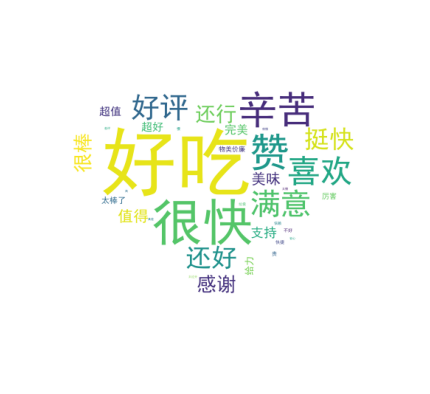

In [158]:
#只看情感词
#积极词汇
data = review_mltype.copy()
data = data[data['amend_weight'] != 0]

word_data_pos = data[data['ml_type'] == 'pos']
word_data_neg = data[data['ml_type'] == 'neg']

background_image = plt.imread('C:/Users/HP/Desktop/data/pic4.jpg')
wordcloud = WordCloud(font_path = font, max_words = 100, mode='RGBA', 
                      background_color = 'white', mask = background_image) #width=1600,height=1200
wordcloud.generate_from_frequencies(Counter(word_data_pos.word.values))

plt.figure(figsize = (15, 7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

<Figure size 1080x504 with 0 Axes>

(-0.5, 563.5, 515.5, -0.5)

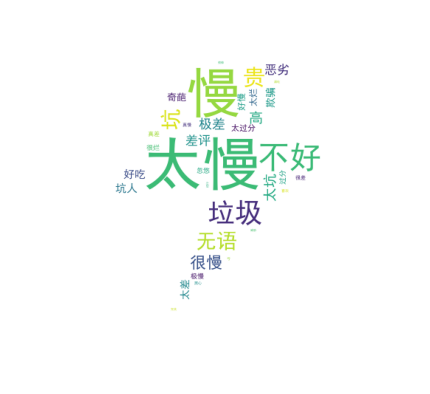

In [160]:
#消极词汇
background_image = plt.imread('C:/Users/HP/Desktop/data/pic5.jpg')
wordcloud = WordCloud(font_path = font, max_words = 100, mode='RGBA', 
                      background_color = 'white', mask = background_image) #width=1600,height=1200
wordcloud.generate_from_frequencies(Counter(word_data_neg.word.values))

plt.figure(figsize = (15,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## （二）情感分类——基于决策树和逻辑斯蒂回归

1、准备工作

In [161]:
# 准备数据
Y = []
for ind in review_long_clean.index_content.unique():
    y = [ word for word in review_long_clean.content_type[review_long_clean.index_content == ind].unique() ]
    Y.append(y)
len(Y)

X = []
for ind in review_long_clean.index_content.unique():
    term = [ word for word in review_long_clean.word[review_long_clean.index_content == ind].values ]
    X.append(' '.join(term))
len(X)

X
Y

11948

11948

['很快 好吃 味道 足 量',
 '送水 送水 送水',
 '态度',
 '快捷 味道 可口 递给 力',
 '菜 味道 很棒 送餐',
 '师傅 手 抖 微辣 辣',
 '送餐 态度 特别 辛苦 谢谢',
 '超级 送到 冷 天气 骑士 辛苦 谢谢你们 麻辣 香锅 依然 好吃',
 '上次 晚 小时 超级 分钟 送到',
 '五分钟 订 卖家 特别 接单 谢谢',
 '量 好吃 每次 点 够吃 两次',
 '挺辣 吃',
 '味道 送餐 分量 足',
 '量 足 好吃 送餐',
 '特别 好吃 量 特大 送餐 特别 特别 特别 棒',
 '口感 速度',
 '好吃 香锅 分量 够 足 味道 的说',
 '好吃 速度 包装 品质 家门 吃 餐厅 味道',
 '味道 好极 送餐 很快 师傅 辛苦',
 '量 味道 送餐 师傅',
 '送餐 师傅 味道 好极',
 '送货 速度 很快 这家 赞',
 '很快 送到 棒',
 '好吃 总点 够 五个 吃 送 很快',
 '香 美味 下次 光顾',
 '送餐 特别 态度 辛苦',
 '服务 不错 送到 很快 半小时 不到 送来',
 '速度 很快 大雾 霾 天 外卖 骑士 态度 赞赞 赞',
 '味道 正宗 量 内容',
 '送餐 态度 特别 谢谢',
 '又快又好 量 足 吃',
 '一盆 点 份量 足',
 '配送 人员 态度 速度',
 '天气 里 感谢 送 餐员 辛苦 服务 谢谢',
 '送餐 特别 态度 非常感谢',
 '送 包装 谢谢 师傅',
 '好吃 麻辣 香锅 开玩笑',
 '味道 不错 份量 很足 建议 点 小份 红薯 超 好吃 太烂 碎',
 '不错 稍微 咸 点',
 '这么晚 辛苦 外卖 小哥',
 '超级 送到 谢谢 骑士 很快 感谢 骑士 天气 工作',
 '好吃 味道 香 推荐',
 '好吃 速递 下次 选择',
 '很快 特别',
 '太麻 青笋 米饭 土豆片 碎 找 不到',
 '点 太 味道 香',
 '态度 地址 填错 跑 一趟 表现 出不 样子 快递 员 写 评论',
 '快递 小哥 很快 送到 赞 水 煮 牛肉 肉质 鲜嫩 辣 恰到好处 入味 不错 挺好吃',
 '口味 不错 干净 味道 送货员 服务',
 '送餐 特别 态度 辛苦 谢谢',
 '送餐 送餐 大哥 态度 辛苦',

[['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],


In [185]:
# 训练集、测试集划分
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 7)

# 词转向量，01矩阵
count_vec = CountVectorizer(binary = True) 
x_train = count_vec.fit_transform(x_train)
x_test = count_vec.transform(x_test)

2、基于决策树进行情感分类

In [186]:
#构建决策树
dtc = tree.DecisionTreeClassifier(max_depth = 5)
dtc.fit(x_train, y_train)
print('在训练集上的准确率：%.2f'% accuracy_score(y_train, dtc.predict(x_train)))

y_true = y_test
y_pred = dtc.predict(x_test)
print('在测试集上的准确率：%.2f'% accuracy_score(y_true, y_pred))

print(classification_report(y_true, y_pred))

DecisionTreeClassifier(max_depth=5)

在训练集上的准确率：0.76
在测试集上的准确率：0.75
              precision    recall  f1-score   support

         neg       0.77      0.89      0.83      1609
         pos       0.67      0.45      0.54       781

    accuracy                           0.75      2390
   macro avg       0.72      0.67      0.68      2390
weighted avg       0.74      0.75      0.73      2390



'C:\\Users\\HP\\Desktop\\data\\tree.svg'

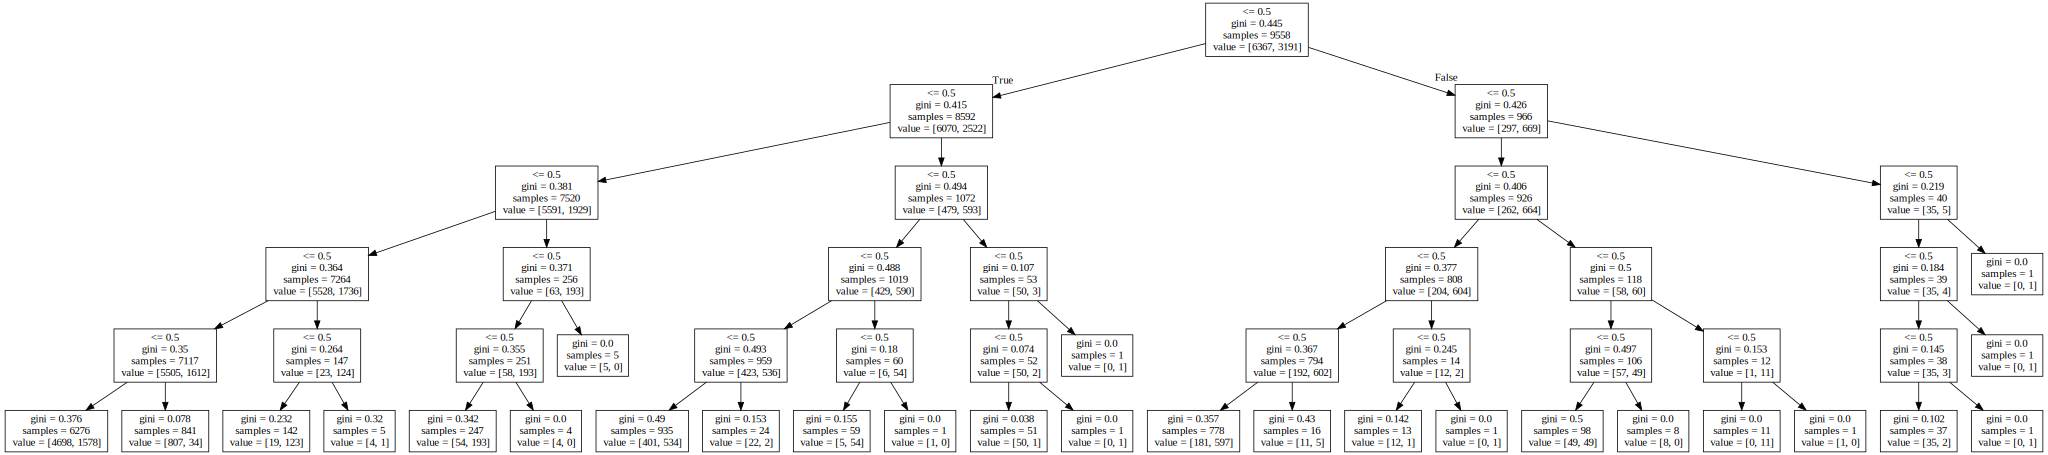

In [187]:
#画决策树
cwd = os.getcwd()
dot_data = tree.export_graphviz(dtc, out_file=None,
                                feature_names = count_vec.get_feature_names())
graph = graphviz.Source(dot_data)
graph.format = 'svg'
graph.render(cwd+'/tree', view=True)
graph

3、基于logistic回归进行情感分类

In [188]:
# 寻找最佳的惩罚项（l1 or l2）及其系数c
l1 = [] 
l2 = [] 
l1test = [] 
l2test = [] 

for i in np.linspace(0.05,1,19): 
    lrl1 = LogisticRegression(penalty = "l1", solver = "liblinear", C = i, max_iter = 1000) 
    lrl2 = LogisticRegression(penalty = "l2", solver = "liblinear", C = i, max_iter = 1000) 
    lrl1 = lrl1.fit(x_train, y_train) 
    l1.append(metrics.accuracy_score(lrl1.predict(x_train), y_train)) 
    l1test.append(metrics.accuracy_score(lrl1.predict(x_test), y_test)) 
    lrl2 = lrl2.fit(x_train,y_train) 
    l2.append(metrics.accuracy_score(lrl2.predict(x_train), y_train)) 
    l2test.append(metrics.accuracy_score(lrl2.predict(x_test), y_test)) 

D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
D:\Anaconda3

D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


<Figure size 648x504 with 0 Axes>

Text(0.5, 1.0, 'The relationship between c and accurancy')

Text(0.5, 0, 'c')

Text(0, 0.5, 'accurancy')

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([0.76, 0.78, 0.8 , 0.82, 0.84, 0.86, 0.88, 0.9 , 0.92]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

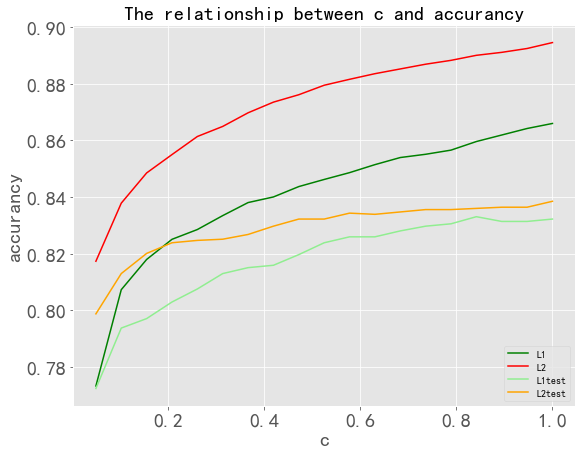

In [189]:
graph = [l1, l2, l1test, l2test] 
color = ["green", "red", "lightgreen", "orange"] 
label = ["L1", "L2", "L1test", "L2test"] 
plt.figure(figsize = (9, 7)) 

for i in range(len(graph)): 
    plt.plot(np.linspace(0.05, 1, 19), graph[i], color[i], label = label[i]) 
    
plt.legend(loc = 4)#图例的位置在哪里,4表示，右下角 
plt.title('The relationship between c and accurancy', fontsize = 20)#标题 
plt.xlabel('c', fontsize = 20)#x轴 
plt.ylabel('accurancy', fontsize = 20)#y轴 
plt.xticks(fontsize = 20)#设置x轴标签字体大小 
plt.yticks(fontsize = 20)#设置y轴标签字体大小 
plt.show()

In [190]:
print("max value of accurancy with l1 penalty:" + str(max(l1test))) 
print("max value of accurancy with l2 penalty:" + str(max(l2test))) 

c = np.argmax(l2test) * 0.05
print("the best value of c with l2 penalty:" + str(c)) 

max value of accurancy with l1 penalty:0.8330543933054393
max value of accurancy with l2 penalty:0.8384937238493724
the best value of c with l2 penalty:0.9


In [191]:
# 用所得的penalty与c进行预测
LRmodel = LogisticRegression(penalty = "l2", solver = "liblinear", C = 0.9, max_iter = 1000)#选逻辑回归作为分类器 
LRmodel.fit(x_train, y_train)#训练模型  
y_pred_train = LRmodel.predict(x_train)
y_pred_test = LRmodel.predict(x_test) 
#x_data=count_vec.fit_transform(X)
#计算评价指标：precision, recall, f1_score 
#LR_s=cross_val_score(rfc,x_data,raw_data['label'],cv=10).mean() 
accuracy_train = metrics.accuracy_score(y_train, y_pred_train) #训练集
accuracy_test = metrics.accuracy_score(y_test, y_pred_test) #测试集

precision = metrics.precision_score(y_test, y_pred_test, pos_label='pos') 
recall = metrics.recall_score(y_test,y_pred_test,pos_label='pos') 
#f1=metrics.f1_score(y_test,y_pred1,pos_label='pos') 
f1 = 2 * precision * recall / (precision + recall)
#print("cross_val_score:"+str(LR_s)) 
print("accuracy_train:" + str(round(accuracy_train,4))) 
print("accuracy_test:" + str(round(accuracy_test,4))) 
print("precision:" + str(round(precision,4))) 
print("recall:" + str(round(recall,4))) 
print("f1:" + str(round(f1,4)))

D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LogisticRegression(C=0.9, max_iter=1000, solver='liblinear')

accuracy_train:0.8911
accuracy_test:0.8368
precision:0.7931
recall:0.6773
f1:0.7307


<Figure size 648x504 with 0 Axes>

Text(0.5, 1.0, 'confusion matrix')

Text(0.5, 44.0, 'predict')

Text(62.0, 0.5, 'real')

(array([0.5, 1.5]), [Text(0.5, 0, 'pos'), Text(1.5, 0, 'neg')])

(array([0.5, 1.5]), [Text(0, 0.5, 'pos'), Text(0, 1.5, 'neg')])

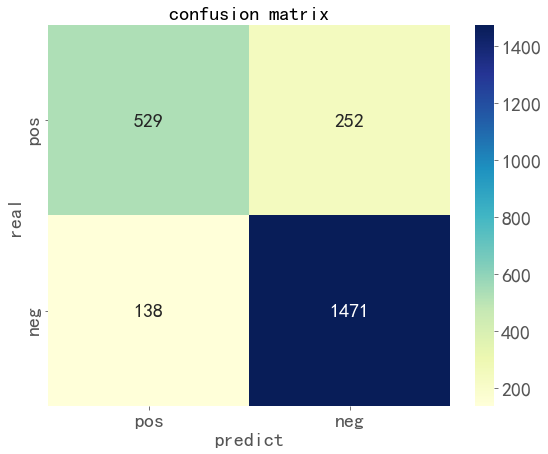

In [193]:
# 输出混淆矩阵
cm = confusion_matrix(y_test, LRmodel.predict(x_test), labels = ['pos','neg']) 
labels=['pos', 'neg'] 
plt.figure(figsize = (9, 7)) 
ax = sns.heatmap(cm, annot = True, 
                 fmt = "d", cmap = "YlGnBu",
                 xticklabels = labels, 
                 yticklabels = labels, 
                 annot_kws = {"fontsize":20}) 
plt.title('confusion matrix', fontsize = 20)#设置标题及其字号 
plt.xlabel('predict', fontsize = 20)#x轴及其字号 
plt.ylabel('real', fontsize = 20)#y轴及其字号 
plt.xticks(fontsize = 20) 
plt.yticks(fontsize = 20) 
cbar = ax.collections[0].colorbar 
cbar.ax.tick_params(labelsize = 20)#设置图例字号 
plt.show()

In [194]:
# 输出分类报告
print(classification_report(y_true = y_test, y_pred = LRmodel.predict(x_test)))

              precision    recall  f1-score   support

         neg       0.85      0.91      0.88      1609
         pos       0.79      0.68      0.73       781

    accuracy                           0.84      2390
   macro avg       0.82      0.80      0.81      2390
weighted avg       0.83      0.84      0.83      2390



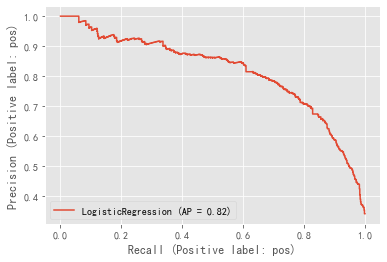

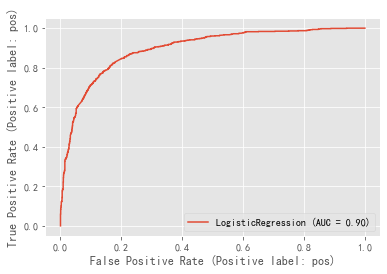

In [195]:
# 输出ROC和PR曲线
metrics.plot_precision_recall_curve(estimator = LRmodel, X = x_test, y = y_test, pos_label = 'pos') #画出ROC曲线 
metrics.plot_roc_curve(estimator = LRmodel, X = x_test, y = y_test, pos_label = 'pos')

### （三）基于LDA的主题分析

1、建立词库、语料库

In [196]:
data = review_mltype.copy()

word_data_pos = data[data['ml_type'] == 'pos']
word_data_neg = data[data['ml_type'] == 'neg']

#建立词典，去重
pos_dict = corpora.Dictionary([ [i] for i in word_data_pos.word]) #shape=(n,1)
neg_dict = corpora.Dictionary([ [i] for i in word_data_neg.word])

print(pos_dict)

Dictionary(3325 unique tokens: ['很快', '好吃', '味道', '足', '量']...)


In [197]:
#建立语料库

pos_corpus = [ pos_dict.doc2bow(j) for j in [ [i] for i in word_data_pos.word] ] #shape=(n,(2,1))
neg_corpus = [ neg_dict.doc2bow(j) for j in [ [i] for i in word_data_neg.word] ]

len(word_data_pos.word)
len(pos_dict)
len(pos_corpus)
pos_corpus  #元素是元组，元组（x,y),x是在词典中的位置，y是1表示存在。

19628

3325

19628

[[(0, 1)],
 [(1, 1)],
 [(2, 1)],
 [(3, 1)],
 [(4, 1)],
 [(5, 1)],
 [(2, 1)],
 [(6, 1)],
 [(7, 1)],
 [(8, 1)],
 [(9, 1)],
 [(2, 1)],
 [(10, 1)],
 [(11, 1)],
 [(11, 1)],
 [(12, 1)],
 [(13, 1)],
 [(14, 1)],
 [(15, 1)],
 [(16, 1)],
 [(17, 1)],
 [(18, 1)],
 [(19, 1)],
 [(20, 1)],
 [(14, 1)],
 [(21, 1)],
 [(22, 1)],
 [(23, 1)],
 [(24, 1)],
 [(1, 1)],
 [(4, 1)],
 [(1, 1)],
 [(25, 1)],
 [(26, 1)],
 [(27, 1)],
 [(28, 1)],
 [(4, 1)],
 [(3, 1)],
 [(1, 1)],
 [(11, 1)],
 [(13, 1)],
 [(1, 1)],
 [(4, 1)],
 [(29, 1)],
 [(11, 1)],
 [(13, 1)],
 [(13, 1)],
 [(13, 1)],
 [(30, 1)],
 [(1, 1)],
 [(23, 1)],
 [(31, 1)],
 [(32, 1)],
 [(3, 1)],
 [(2, 1)],
 [(33, 1)],
 [(1, 1)],
 [(34, 1)],
 [(35, 1)],
 [(36, 1)],
 [(37, 1)],
 [(38, 1)],
 [(39, 1)],
 [(2, 1)],
 [(2, 1)],
 [(40, 1)],
 [(11, 1)],
 [(0, 1)],
 [(41, 1)],
 [(14, 1)],
 [(42, 1)],
 [(34, 1)],
 [(0, 1)],
 [(43, 1)],
 [(44, 1)],
 [(0, 1)],
 [(17, 1)],
 [(30, 1)],
 [(1, 1)],
 [(45, 1)],
 [(32, 1)],
 [(46, 1)],
 [(38, 1)],
 [(47, 1)],
 [(0, 1)],
 [(48, 1)],

2、主题数寻优

In [199]:
#构造主题数寻优函数

def cos(vector1,vector2):
    '''
    函数功能：余玄相似度函数
    '''
    dot_product = 0.0
    normA = 0.0
    normB = 0.0
    for a, b in zip(vector1, vector2):
        dot_product += a*b
        normA += a**2
        normB += b**2
    if normA == 0.0 or normB == 0.0:
        return None
    else:
        return ( dot_product/((normA*normB)**0.5) )

In [200]:
def LDA_k(x_corpus, x_dict):
    #初始化平均余玄相似度
    mean_similarity = []
    mean_similarity.append(1)
    
    #循环生成主题并计算主题间相似度
    for i in np.arange(2, 11):
        lda = models.LdaModel(x_corpus, num_topics = i, id2word = x_dict) #LDA模型训练
        
        for j in np.arange(i):
            term = lda.show_topics(num_words = 50)
        
        #提取各主题词
        top_word = [] #shape=(i,50)
        for k in np.arange(i):
            top_word.append( [''.join(re.findall('"(.*)"',i)) for i in term[k][1].split('+')]) #列出所有词
        
        #构造词频向量
        word = sum(top_word,[]) #列出所有词
        unique_word = set(word) #去重
        
        #构造主题词列表，行表示主题号，列表示各主题词
        mat = [] #shape=(i,len(unique_word))
        for j in np.arange(i):
            top_w = top_word[j]
            mat.append( tuple([ top_w.count(k) for k in unique_word ])) #统计list中元素的频次，返回元组
        
        #两两组合。方法一
        p = list(itertools.permutations(list(np.arange(i)), 2)) #返回可迭代对象的所有数学全排列方式。
        y = len(p) # y=i*(i-1)
        top_similarity = [0]
        for w in np.arange(y):
            vector1 = mat[p[w][0]]
            vector2 = mat[p[w][1]]
            top_similarity.append(cos(vector1,vector2))
            #计算平均余玄相似度
        mean_similarity.append(sum(top_similarity)/ y)
    return mean_similarity

[1,
 0.0,
 0.0,
 0.0033333333333333335,
 0.006,
 0.0013333333333333333,
 0.0028571428571428576,
 0.023571428571428583,
 0.056111111111111146,
 0.07377777777777775]

[1,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0028571428571428576,
 0.006428571428571428,
 0.008888888888888892,
 0.017777777777777788]

<AxesSubplot:>

Text(0.5, 1.0, '正面评论LDA主题数寻优')

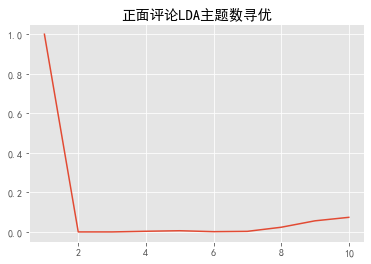

In [201]:
#计算主题平均余玄相似度

pos_k = LDA_k(pos_corpus, pos_dict)
neg_k = LDA_k(neg_corpus, neg_dict)

pos_k
neg_k

pd.Series(pos_k, index = range(1, 11)).plot()
plt.title('正面评论LDA主题数寻优')
plt.show()

<AxesSubplot:>

Text(0.5, 1.0, '负面评论LDA主题数寻优')

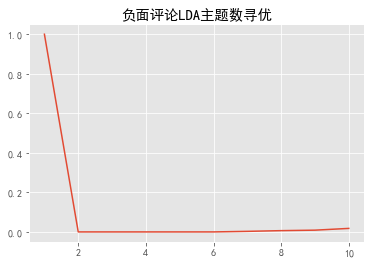

In [202]:
pd.Series(neg_k, index = range(1,11)).plot()
plt.title('负面评论LDA主题数寻优')
plt.show()

In [203]:
pos_lda = models.LdaModel(pos_corpus, num_topics = 2, id2word = pos_dict)
neg_lda = models.LdaModel(neg_corpus, num_topics = 2, id2word = neg_dict)

pos_lda.print_topics(num_topics = 10)

[(0,
  '0.028*"送" + 0.027*"吃" + 0.016*"菜" + 0.015*"饭" + 0.014*"满意" + 0.013*"外卖" + 0.012*"送到" + 0.011*"辛苦" + 0.010*"时间" + 0.009*"差"'),
 (1,
  '0.110*"好吃" + 0.030*"味道" + 0.028*"太" + 0.026*"送餐" + 0.026*"很快" + 0.018*"点" + 0.016*"不错" + 0.016*"速度" + 0.013*"还好" + 0.012*"小时"')]

In [205]:
neg_lda.print_topics(num_words=10)

[(0,
  '0.045*"送餐" + 0.043*"小时" + 0.038*"送" + 0.025*"点" + 0.020*"速度" + 0.018*"味道" + 0.018*"吃" + 0.015*"差" + 0.015*"凉" + 0.014*"打电话"'),
 (1,
  '0.069*"太慢" + 0.045*"慢" + 0.021*"送到" + 0.019*"不好" + 0.018*"太" + 0.014*"垃圾" + 0.014*"送来" + 0.013*"饭" + 0.012*"时间" + 0.012*"态度"')]